In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Pull in data.

In [2]:
data = pd.read_csv('data/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
bp_all = data['BloodPressure']
bp_all = bp_all[bp_all != 0]

### Bayesian Inference

In this notebook we are going to show a very basic example of Bayesian Inference.

We are going to use the pymc package to perform the Metropolis-Hastings Algorithm on the Blood Pressure variable. The Metropolis-Hastings Algorithm is a Markov Chain Monte Carlo (MCMC) method that is used in Bayesian Inference. In Bayesian Inference, one treats the moments (in our case the mean and standard deviation) of our sampled Random Variable as Random Variables themelves. In doing so, one can impart information about these moments in search of the populations's moments (the moments of the true distribution, rather than the sampled distribution).

Bayes Theorem: $ P(\theta | X) = \frac {P(X | \theta) P(\theta)}{P(X)} $

Where,

$ \theta = $ the set of moments we are interested in modeling

$ X = $ the sampled data

$ P(\theta | X) = $ the "posterior distribution", which is the probability of the moments given the sampled data.

$ P(X | \theta) = $ the "likelihood", which is the probability of our data occurring given the moments of their underlying distribution.

$ P(\theta) = $ the "prior distribution", which is the probability of our moments (we pick their underlying distribution).

$ P(X) = \int_\theta P(X | \theta) P(\theta) d \theta = $ the "normalization", which is the unconditional probability of our data occurring or the integral of the likelihood multiplied by the prior with respect to $\theta$ for all possible values of $\theta$. This term is the reason why an analytical solution to the form of Bayes' theorem that we see above does not always exist and which leads us to use MCMC modeling istead.


Say, for example, that we only have access to 20 draws from our dataset and the full dataset represents the entire Pima Indian population.  We are interested in finding the mean and standard deviation of the population's distribution and to do so, we will assume that the mean and the standard deviation are themselves Random Variables. 

We will also assume that the population mean is Normally distributed. Diastolic blood pressure is considered at a normal level if it's inbetween 60 and 80. For the sake of our analysis we will assume that the mode of this distribution is 70 and that the standard deviation is 5. By the Normal distribution's empirical rule, this means that the true mean of the blood pressure of the population of Pima Indians has a 95% chance of being within the normal range. We are also interested in finding the standard deviation of the blood pressure of the population. For the sake of simplicity, we will assume this variable is Lognormal and has a mode of 10 (where $\mu=2.5$ and $\sigma=0.44$). Since we are assuming that the distribution of blood pressure is Normal with a mean of 70 and a standard devation of 10, then by the Normal distribution's empirical rule, 68% of the Pima Indian population would have a diastolic blood pressure between 60 and 80, which is the range of normal readings. This all seems reasonable.

Sample the data.

In [4]:
np.random.seed(19)
bp_sub = np.random.choice(bp_all, size=20, replace=False, p=None)

Below we plot our population data vs. our sampled data. The sampled data does not look Normal, but we will assume that it is (this assumption imparts more bias into the model).

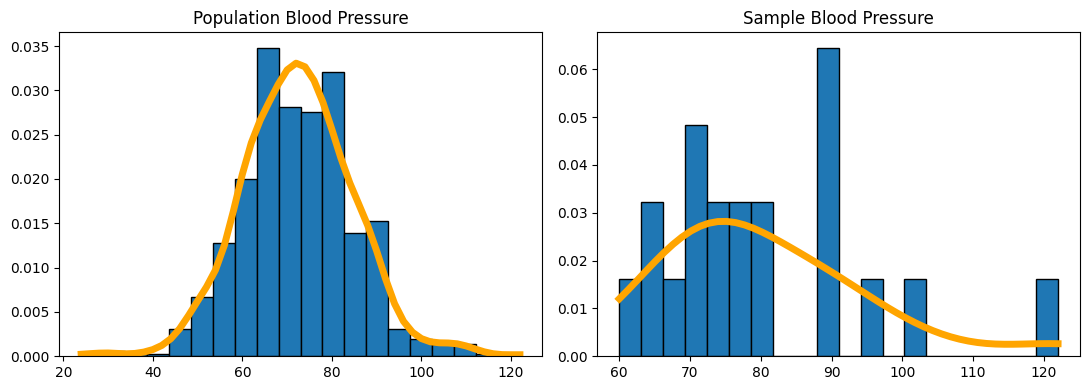

In [5]:
fig, axs = plt.subplots(1, 2, figsize=[11,4])

axs[0].hist(bp_all, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_all)
lin = np.linspace(bp_all.min(), bp_all.max(), 50)
axs[0].plot(lin, x(lin), color='orange', linewidth=5)
axs[0].set_title('Population Blood Pressure')

axs[1].hist(bp_sub, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_sub)
lin = np.linspace(bp_sub.min(), bp_sub.max(), 50)
axs[1].plot(lin, x(lin), color='orange', linewidth=5)
axs[1].set_title('Sample Blood Pressure')
        
fig.tight_layout()
plt.show()

The sample mean and sample standard deviation are both larger than the population mean and population standard deviation, respectively.

In [6]:
print('              Blood Pressure Population Mean: %.2f' % bp_all.mean())
print('Blood Pressure Population Standard Deviation: %.2f' % bp_all.std())
print('\n                  Blood Pressure Sample Mean: %.2f' % bp_sub.mean())
print('    Blood Pressure Sample Standard Deviation: %.2f' % bp_sub.std())

              Blood Pressure Population Mean: 72.41
Blood Pressure Population Standard Deviation: 12.38

                  Blood Pressure Sample Mean: 80.55
    Blood Pressure Sample Standard Deviation: 14.10


We now sample our posterior mean and standard deviation distributions using MCMC.

In [7]:
with pm.Model():
    mu = pm.Normal('mu', mu=70, sigma=5)
    sigma = pm.Lognormal('sigma', mu=2.5, sigma=0.44)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=bp_sub)
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step, random_seed=8)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


We see that the mode of our mean distribution is lower than the sample mean, which is getting closer to the population mean.

In [8]:
stacked = az.extract(trace)
kde = ss.gaussian_kde(stacked.mu.values)
lin = np.linspace(stacked.mu.values.min(), stacked.mu.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the mu distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the mu distribution is 77.30


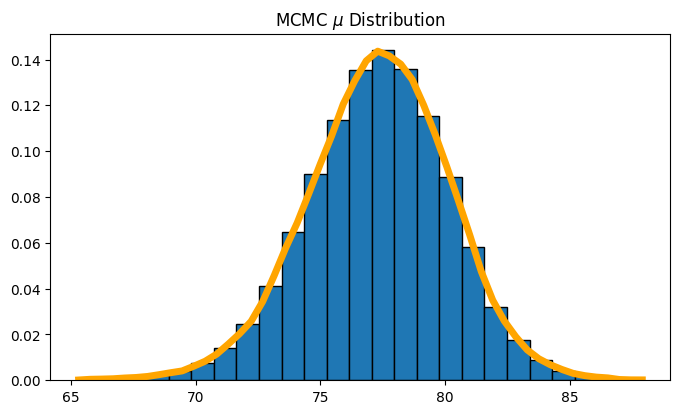

In [9]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\mu$ Distribution')
plt.show()

We see that the mode of our standard deviation distribution is lower than the standard deviation of our sample distribution, getting closer to the population standard deviation.

In [10]:
kde = ss.gaussian_kde(stacked.sigma.values)
lin = np.linspace(stacked.sigma.values.min(), stacked.sigma.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the sigma distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the sigma distribution is 13.83


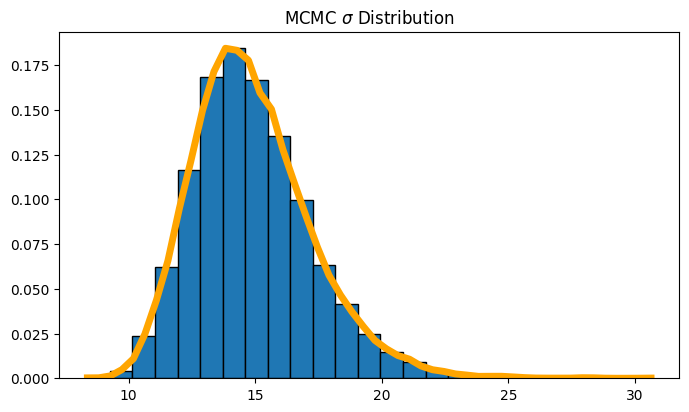

In [11]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\sigma$ Distribution')
plt.show()

Let's take another sample of our population.

In [12]:
np.random.seed(25)
bp_sub = np.random.choice(bp_all, size=20, replace=False, p=None)

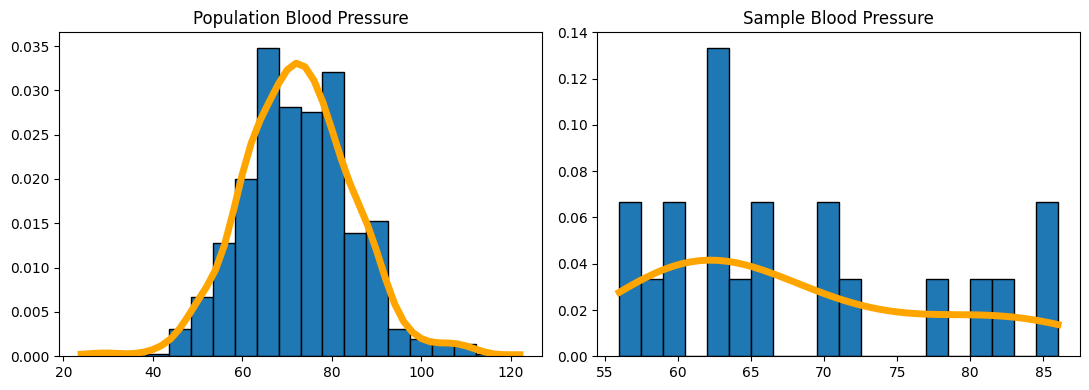

In [13]:
fig, axs = plt.subplots(1, 2, figsize=[11,4])

axs[0].hist(bp_all, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_all)
lin = np.linspace(bp_all.min(), bp_all.max(), 50)
axs[0].plot(lin, x(lin), color='orange', linewidth=5)
axs[0].set_title('Population Blood Pressure')

axs[1].hist(bp_sub, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_sub)
lin = np.linspace(bp_sub.min(), bp_sub.max(), 50)
axs[1].plot(lin, x(lin), color='orange', linewidth=5)
axs[1].set_title('Sample Blood Pressure')
        
fig.tight_layout()
plt.show()

The sample mean and sample standard deviation are both lower than than the population mean and population standard deviation, respectively.

In [14]:
print('              Blood Pressure Population Mean: %.2f' % bp_all.mean())
print('Blood Pressure Population Standard Deviation: %.2f' % bp_all.std())
print('\n                  Blood Pressure Sample Mean: %.2f' % bp_sub.mean())
print('    Blood Pressure Sample Standard Deviation: %.2f' % bp_sub.std())

              Blood Pressure Population Mean: 72.41
Blood Pressure Population Standard Deviation: 12.38

                  Blood Pressure Sample Mean: 67.80
    Blood Pressure Sample Standard Deviation: 9.39


In [15]:
with pm.Model():
    mu = pm.Normal('mu', mu=70, sigma=5)
    sigma = pm.Lognormal('sigma', mu=2.5, sigma=0.44)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=bp_sub)
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step, random_seed=8)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


We see that the mode of our mean distribution is higher than the sample mean, getting closer to the population mean.

In [16]:
stacked = az.extract(trace)
kde = ss.gaussian_kde(stacked.mu.values)
lin = np.linspace(stacked.mu.values.min(), stacked.mu.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the mu distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the mu distribution is 68.29


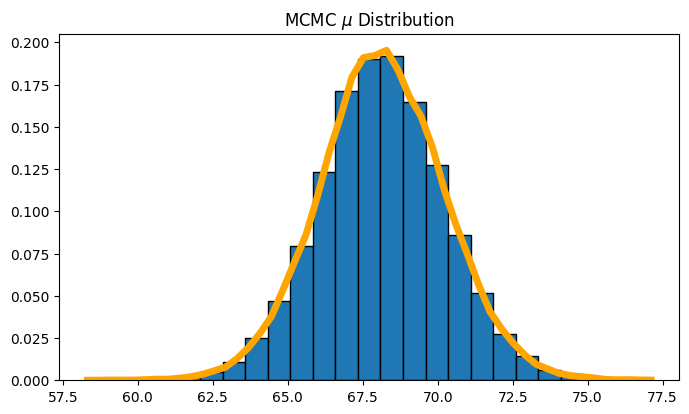

In [17]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\mu$ Distribution')
plt.show()

We see that the mode of our standard deviation distribution is higher than the standard deviation of our sample distribution, getting closer to the population standard deviation.

In [18]:
kde = ss.gaussian_kde(stacked.sigma.values)
lin = np.linspace(stacked.sigma.values.min(), stacked.sigma.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the sigma distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the sigma distribution is 9.49


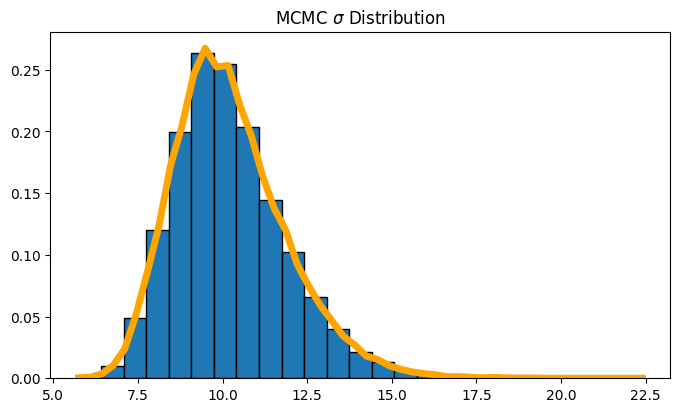

In [19]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\sigma$ Distribution')
plt.show()

So, why is this important?

Bayesian inference allows us to impart prior information about the distribution of our data into our model, which can lead us to find sample moments that are closer to the population's moments than if we interpreted the data as frequentists. However, as helpful as this can be, the fact that we are able to inject bias into our modeling leaves opportunity for us to make incorrect assumptions and therefore push our model further away from the truth.

We show an example of this below. We use the same sample data from the most recent model above.

In [20]:
print('              Blood Pressure Population Mean: %.2f' % bp_all.mean())
print('Blood Pressure Population Standard Deviation: %.2f' % bp_all.std())
print('\n                  Blood Pressure Sample Mean: %.2f' % bp_sub.mean())
print('    Blood Pressure Sample Standard Deviation: %.2f' % bp_sub.std())

              Blood Pressure Population Mean: 72.41
Blood Pressure Population Standard Deviation: 12.38

                  Blood Pressure Sample Mean: 67.80
    Blood Pressure Sample Standard Deviation: 9.39


We will assume that our underlying data is still Normal, but has a mean of 60, rather than 70. We will also assume that our standard deviation has a mode of 8 (with $\mu=2.25$ and $\sigma=0.41$), rather than 10.

In [21]:
with pm.Model():
    mu = pm.Normal('mu', mu=60, sigma=5)
    sigma = pm.Lognormal('sigma', mu=2.25, sigma=0.41)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=bp_sub)
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step, random_seed=8)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


The mode of our mean distribution moves further away from the true population mean because of the prior that we chose.

In [22]:
stacked = az.extract(trace)
kde = ss.gaussian_kde(stacked.mu.values)
lin = np.linspace(stacked.mu.values.min(), stacked.mu.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the mu distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the mu distribution is 66.63


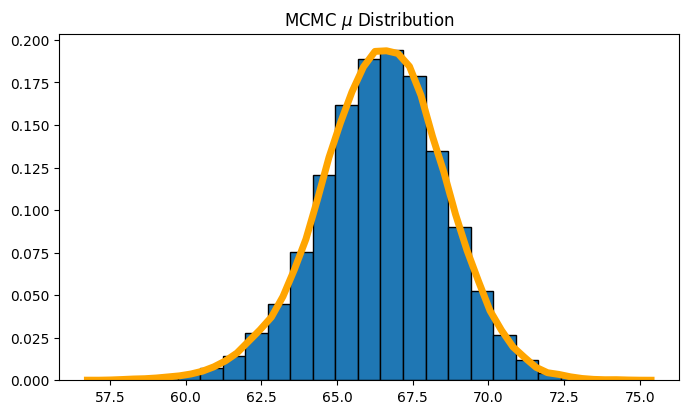

In [23]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\mu$ Distribution')
plt.show()

The mode of our sigma distribution moves further away from our population standard deviation because of the prior we chose.

In [24]:
kde = ss.gaussian_kde(stacked.sigma.values)
lin = np.linspace(stacked.sigma.values.min(), stacked.sigma.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the sigma distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the sigma distribution is 9.33


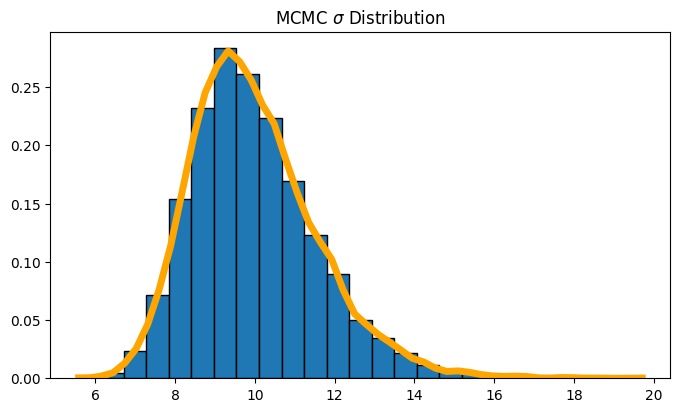

In [25]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\sigma$ Distribution')
plt.show()

In conclusion, while Bayesian Inference can be a useful tool to determine a population's moments, imparting incorrect bias into the model can lead to erroneous outcomes.